In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity


In [7]:
epl = pd.read_csv("D:\Time Series Forecasting\Final statistics\EPL_14_20_players_stat.csv")
bundesliga = pd.read_csv("D:\Time Series Forecasting\Final statistics\Bundesliga_14_20_players_stat.csv")
laliga = pd.read_csv("D:\Time Series Forecasting\Final statistics\laliga_14_20_players_stat.csv")

epl["League"] = "EPL"
bundesliga["League"] = "Bundesliga"
laliga["League"] = "LaLiga"

df = pd.concat([epl, bundesliga, laliga], ignore_index=True)

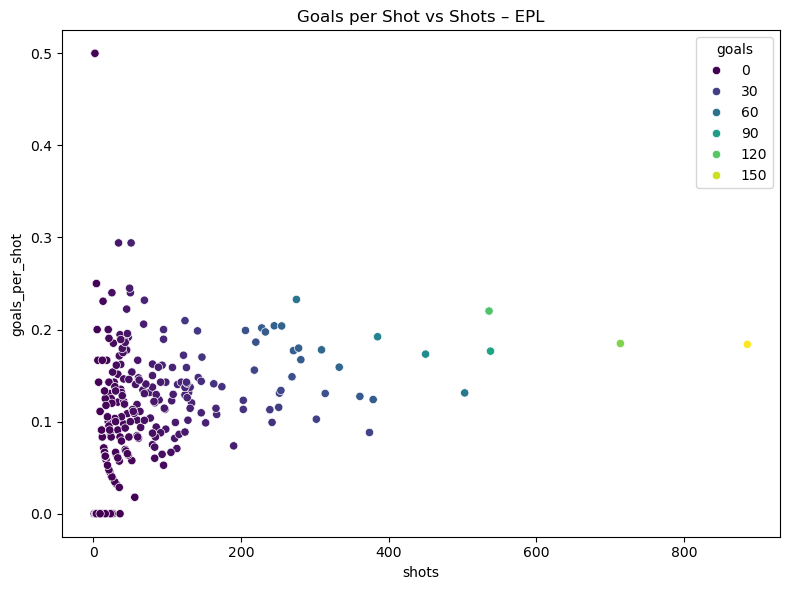

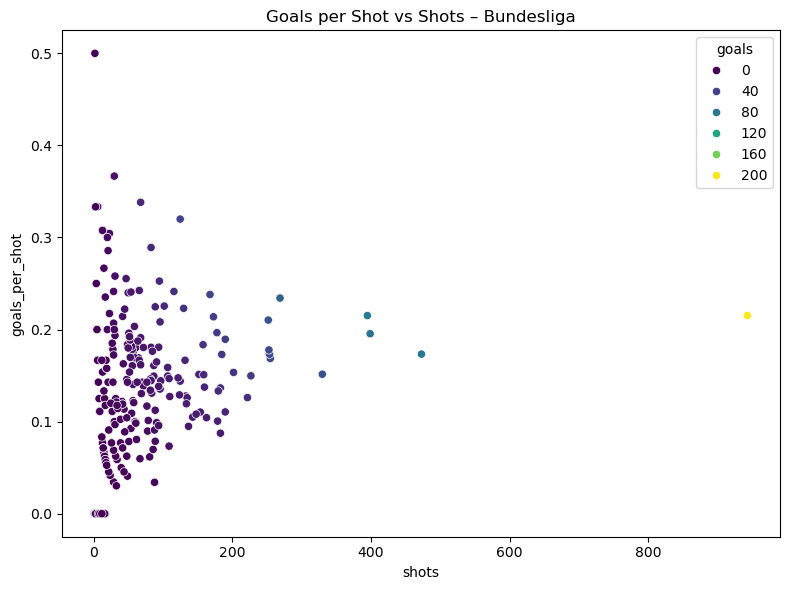

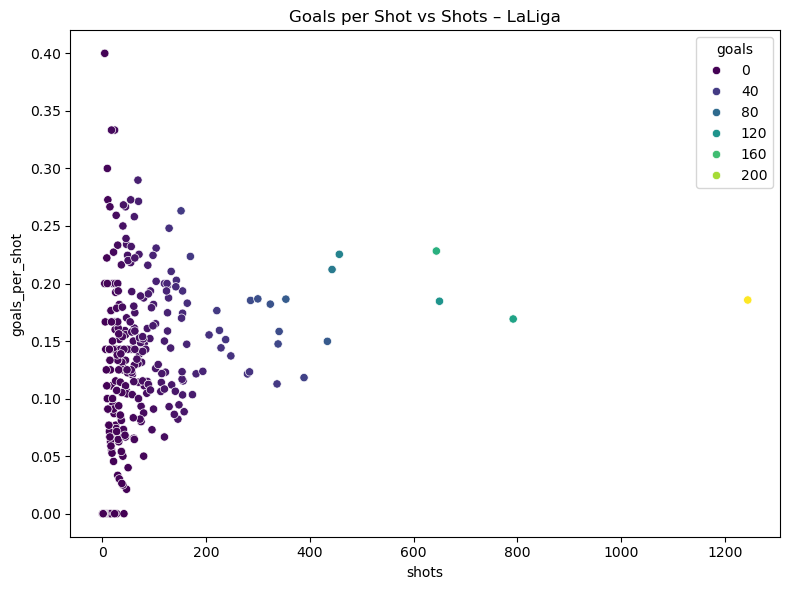

In [8]:
leagues = df["League"].unique()
for league in leagues:
    league_df = df[(df["League"] == league) &
                    (df["unit"] == "Attacking") &
                    (df["shots"] > 0)].copy()

    league_df["goals_per_shot"] = league_df["goals"] / league_df["shots"]

    plt.figure(figsize=(8,6))
    sns.scatterplot(
        x=league_df["shots"],
        y=league_df["goals_per_shot"],
        hue=league_df["goals"],
        palette="viridis"
    )
    plt.title(f"Goals per Shot vs Shots – {league}")
    plt.tight_layout()
    plt.show()


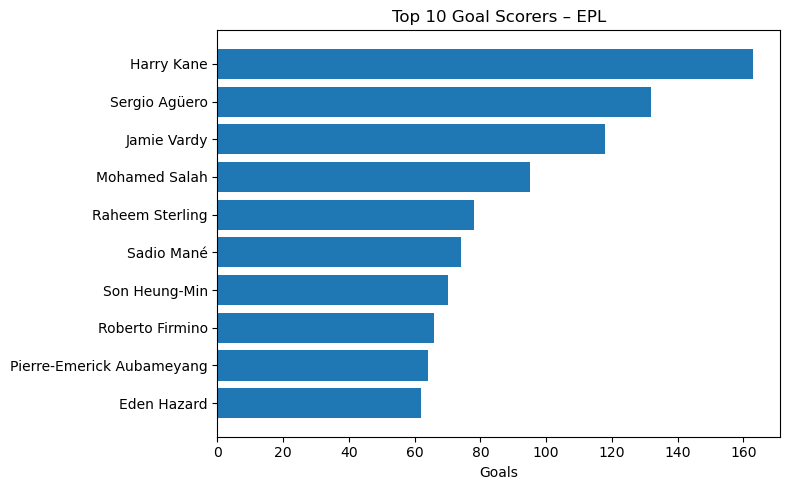

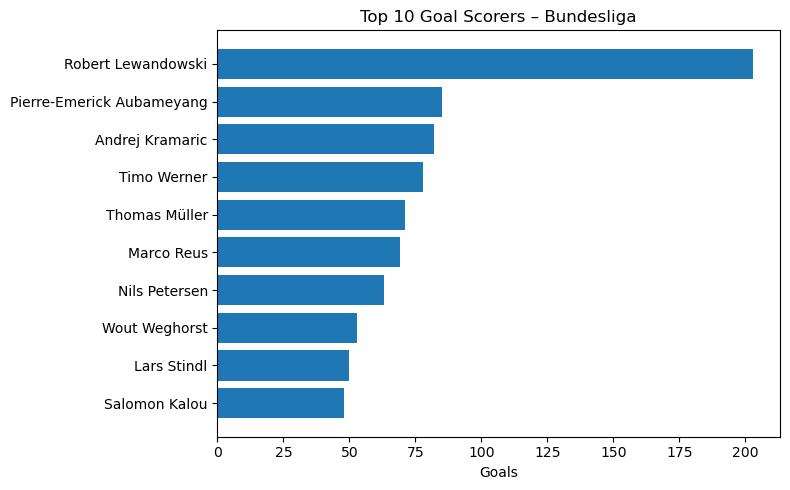

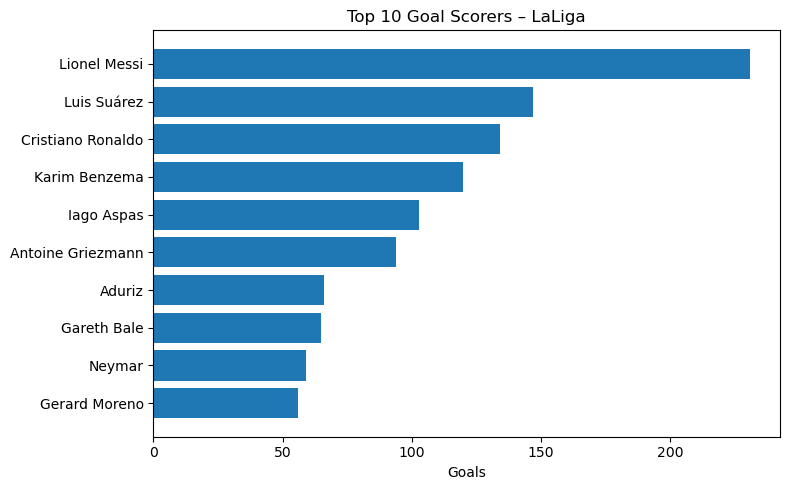

In [9]:
for league in leagues:
    top = (
        df[df["League"] == league]
        .sort_values("goals", ascending=False)
        .head(10)
    )

    plt.figure(figsize=(8,5))
    plt.barh(top["Player Name"], top["goals"])
    plt.gca().invert_yaxis()
    plt.title(f"Top 10 Goal Scorers – {league}")
    plt.xlabel("Goals")
    plt.tight_layout()
    plt.show()


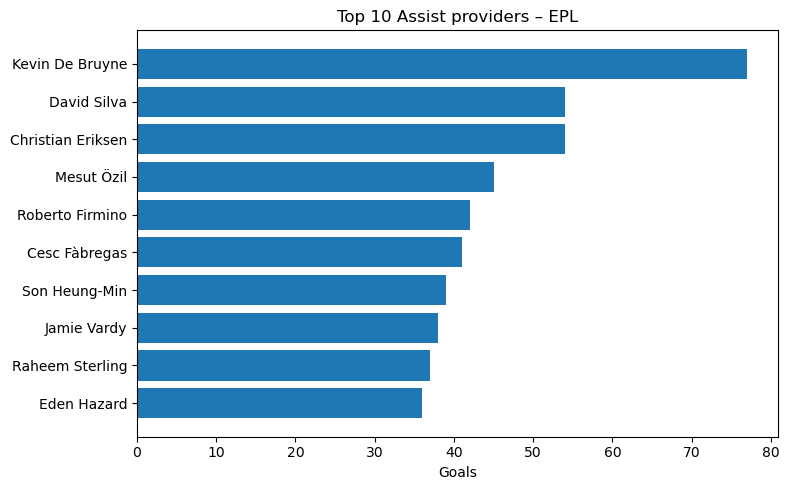

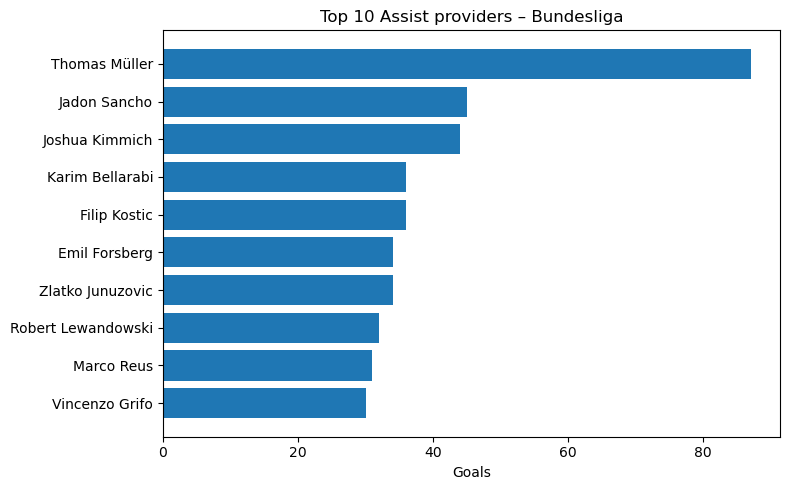

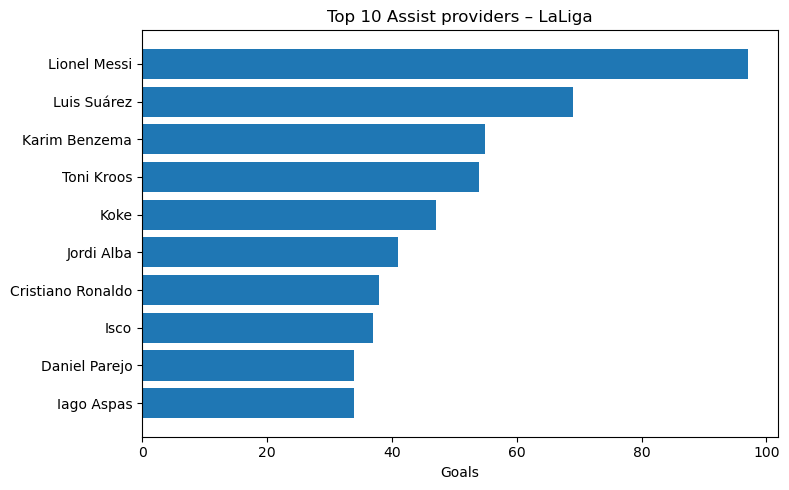

In [55]:
for league in leagues:
    top = (
        df[df["League"] == league]
        .sort_values("assists", ascending=False)
        .head(10)
    )

    plt.figure(figsize=(8,5))
    plt.barh(top["Player Name"], top["assists"])
    plt.gca().invert_yaxis()
    plt.title(f"Top 10 Assist providers – {league}")
    plt.xlabel("Goals")
    plt.tight_layout()
    plt.show()

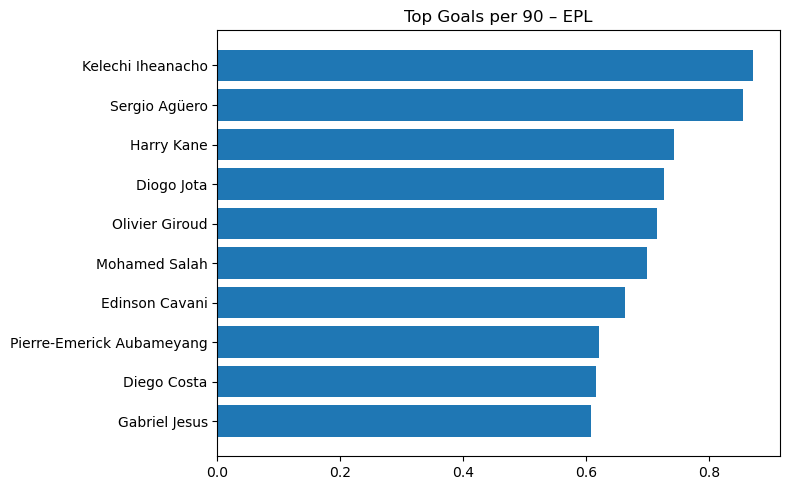

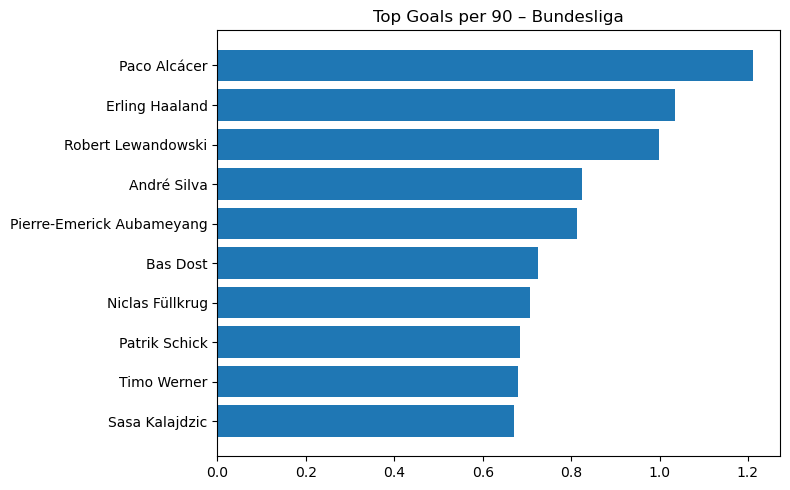

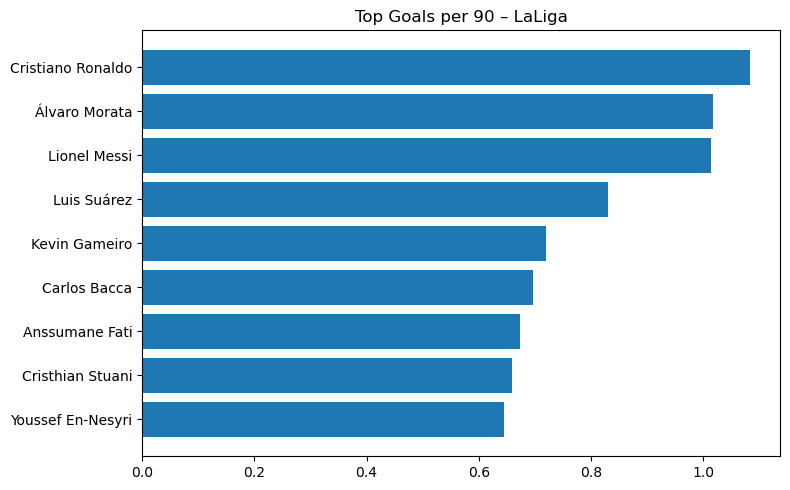

In [10]:
for league in leagues:
    per90 = (
        df[(df["League"] == league) & (df["minutes"] >= 1000)]
        .sort_values("goals_per90", ascending=False)
        .head(10)
    )

    plt.figure(figsize=(8,5))
    plt.barh(per90["Player Name"], per90["goals_per90"])
    plt.gca().invert_yaxis()
    plt.title(f"Top Goals per 90 – {league}")
    plt.tight_layout()
    plt.show()


In [56]:
df["xg_diff"] = df["goals"] - df["xg"]

top_over = df.sort_values("xg_diff", ascending=False).head(10)
top_under = df.sort_values("xg_diff").head(10)

print("\nTop Overperformers:\n", top_over[["Player Name","League","goals","xg","xg_diff"]])
print("\nTop Underperformers:\n", top_under[["Player Name","League","goals","xg","xg_diff"]])


Top Overperformers:
             Player Name      League  goals          xg    xg_diff
3706       Lionel Messi      LaLiga    231  192.348809  38.651191
1485         Harry Kane         EPL    163  138.163675  24.836325
3634  Antoine Griezmann      LaLiga     94   71.479198  22.520802
3812         Iago Aspas      LaLiga    103   84.865983  18.134017
1471      Son Heung-Min         EPL     70   52.054741  17.945259
365         Eden Hazard         EPL     62   46.138779  15.861221
5043    James Rodríguez      LaLiga     29   14.867665  14.132335
2450      Nils Petersen  Bundesliga     63   48.990908  14.009092
17       Olivier Giroud         EPL     46   33.899771  12.100229
1999       Arjen Robben  Bundesliga     43   31.463422  11.536578

Top Underperformers:
              Player Name      League  goals         xg    xg_diff
910        Gabriel Jesus         EPL     50  65.900068 -15.900068
5461             Rodrigo      LaLiga     38  52.493085 -14.493085
435    Christian Benteke       

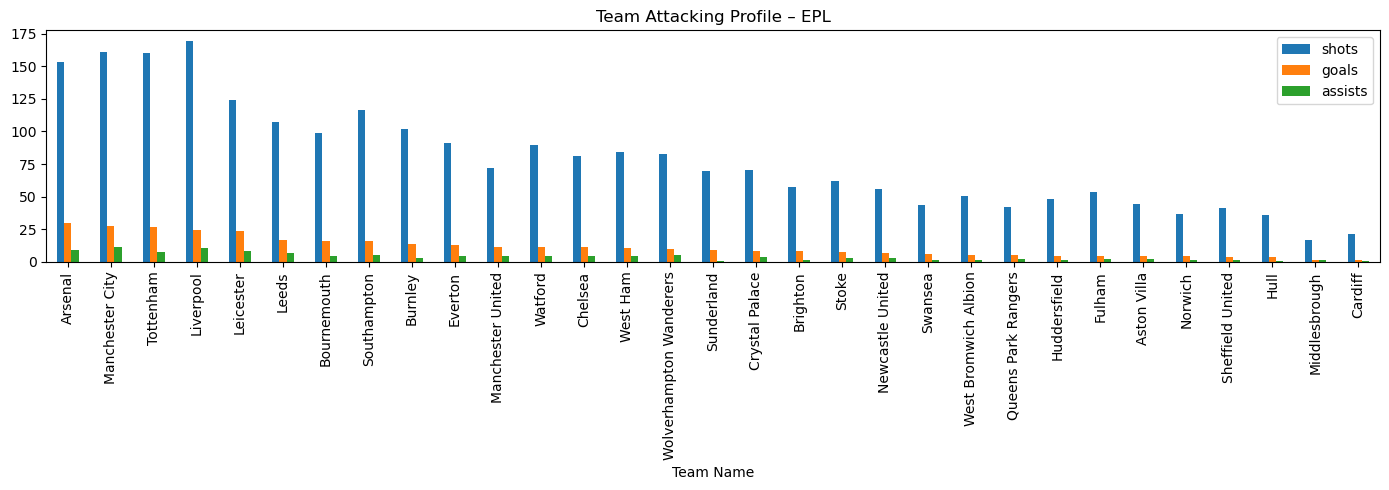

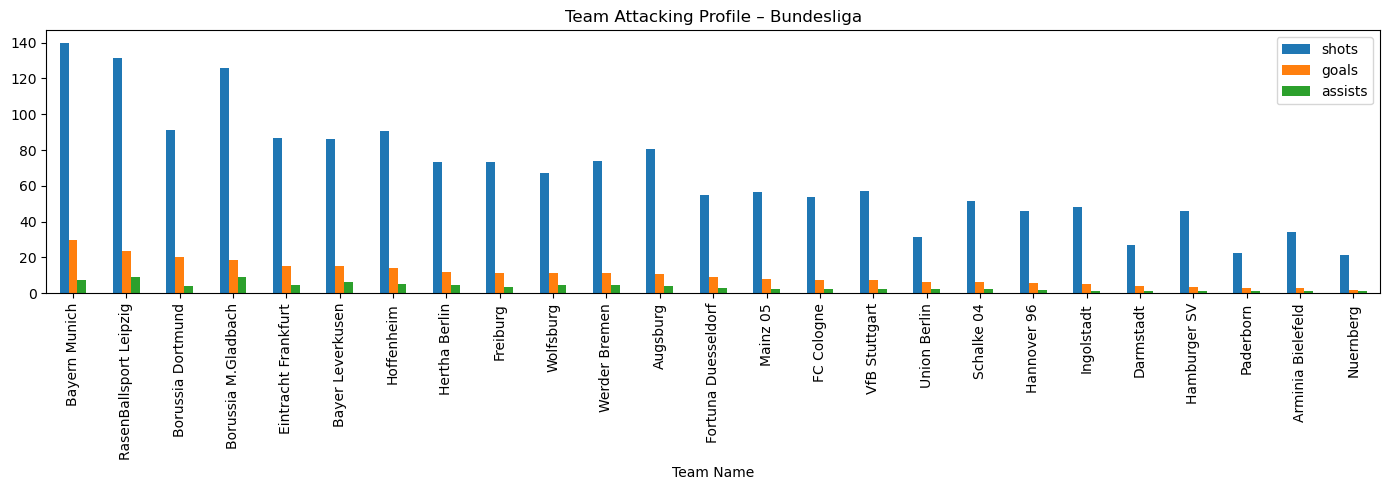

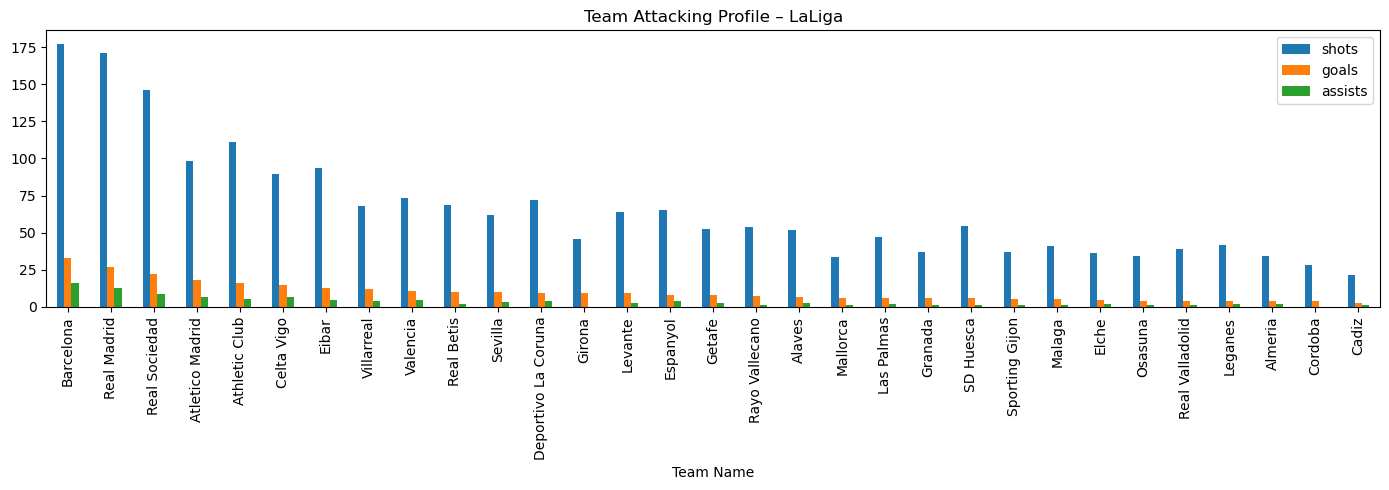

In [13]:
for league in leagues:
    team_attack = (
        df[(df["League"] == league) & (df["unit"] == "Attacking")]
        .groupby("Team Name")[["shots","goals","assists"]]
        .mean()
        .sort_values("goals", ascending=False)
    )

    team_attack.plot(kind="bar", figsize=(14,5))
    plt.title(f"Team Attacking Profile – {league}")
    plt.tight_layout()
    plt.show()


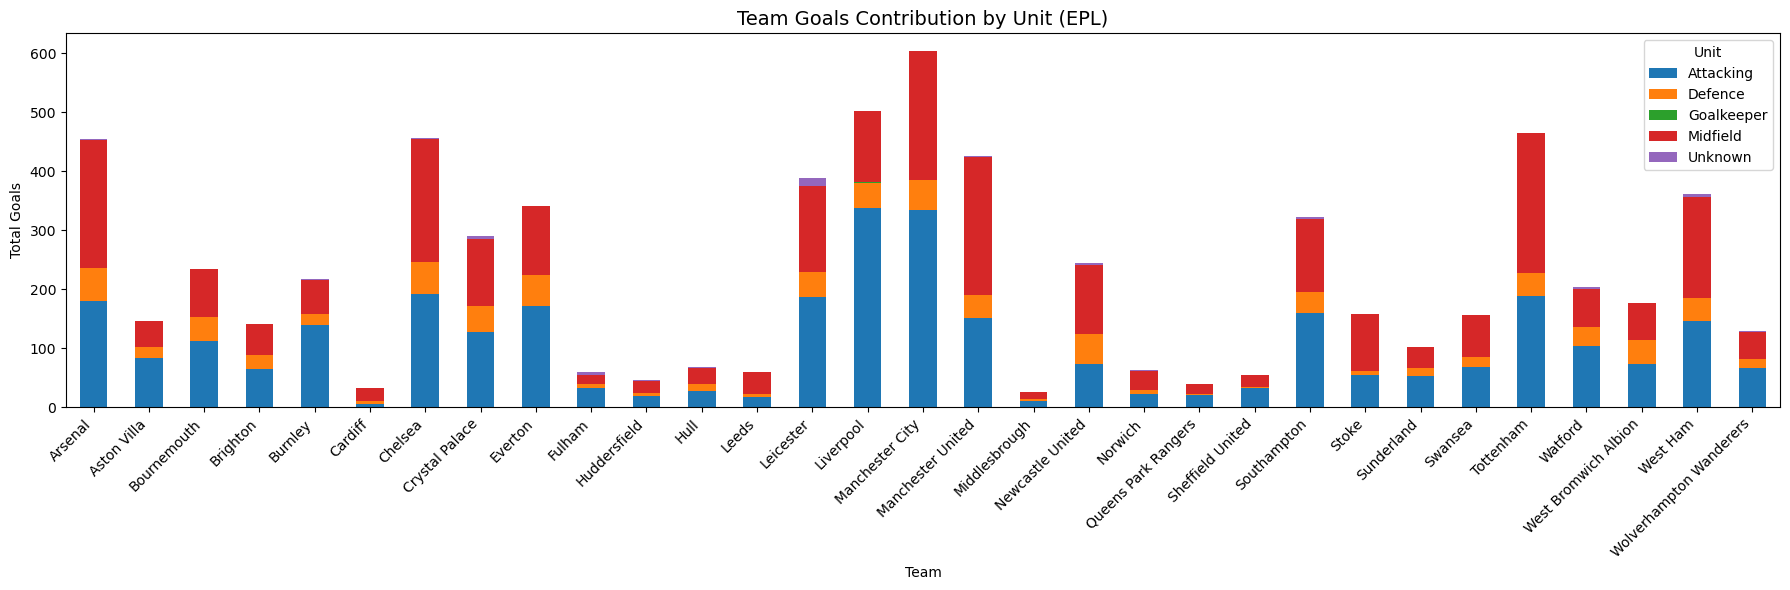

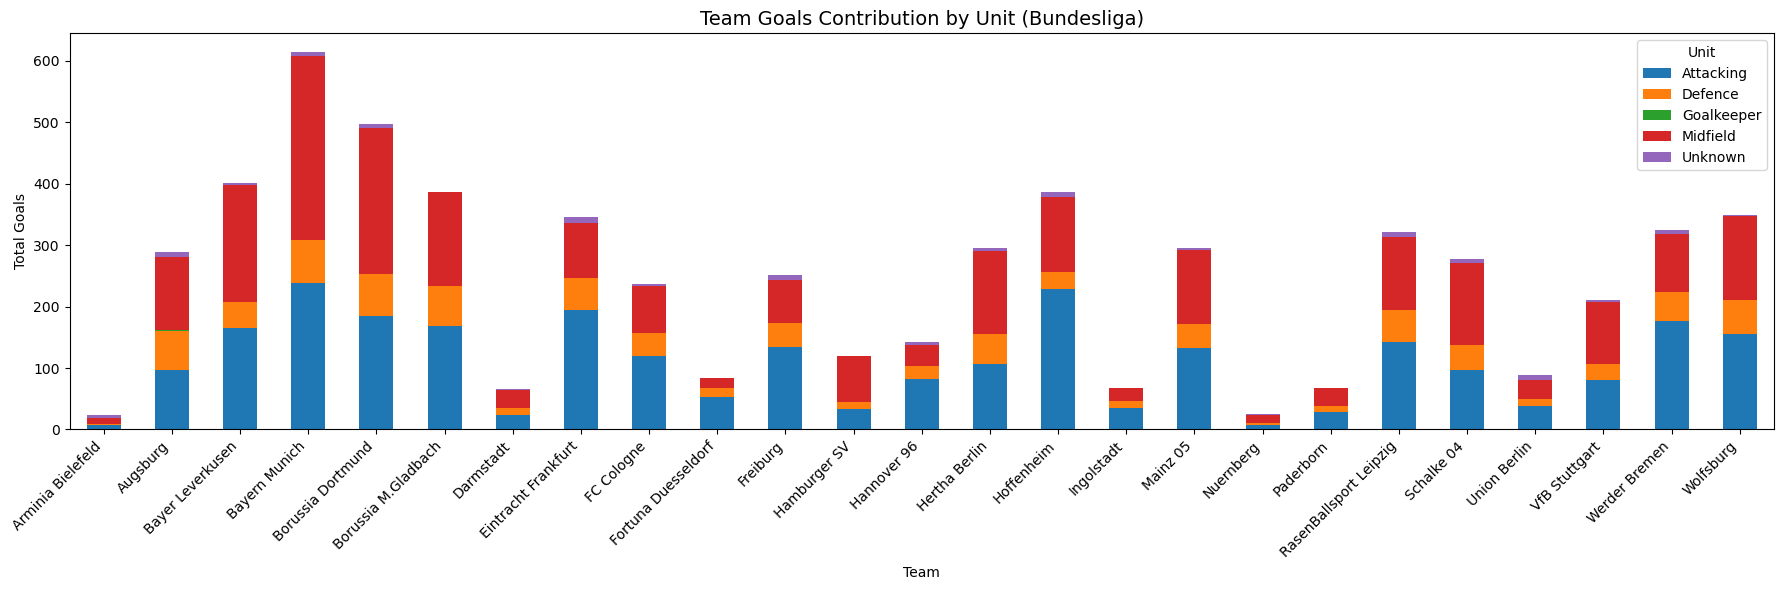

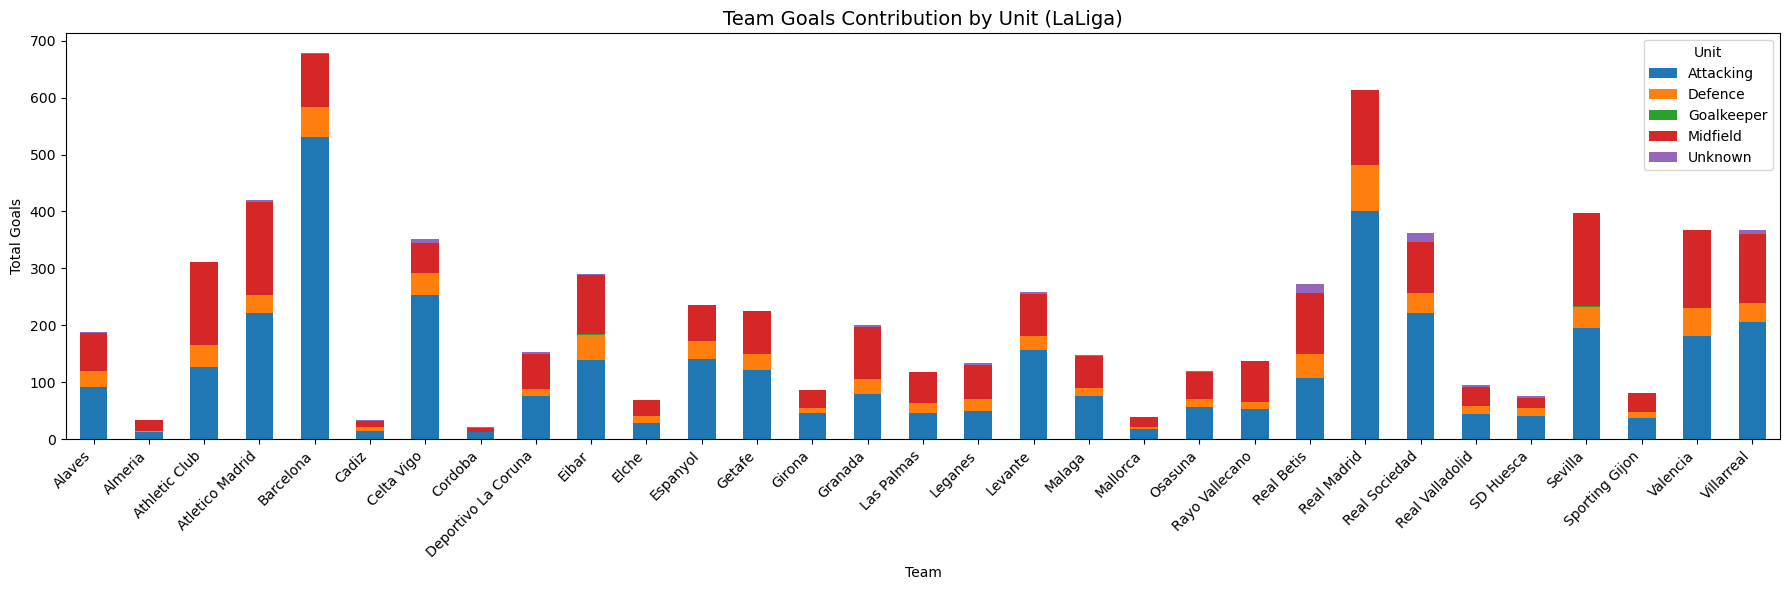

In [54]:
for league in leagues:

    league_df = df[df["League"] == league]

    team_unit_goals = (
        league_df
        .groupby(["Team Name", "unit"])["goals"]
        .sum()
        .unstack()
        .fillna(0)
    )

    fig, ax = plt.subplots(figsize=(18,6))

    team_unit_goals.plot(
        kind="bar",
        stacked=True,
        ax=ax
    )

    ax.set_title(f"Team Goals Contribution by Unit ({league})", fontsize=14)
    ax.set_xlabel("Team")
    ax.set_ylabel("Total Goals")
    ax.legend(title="Unit")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


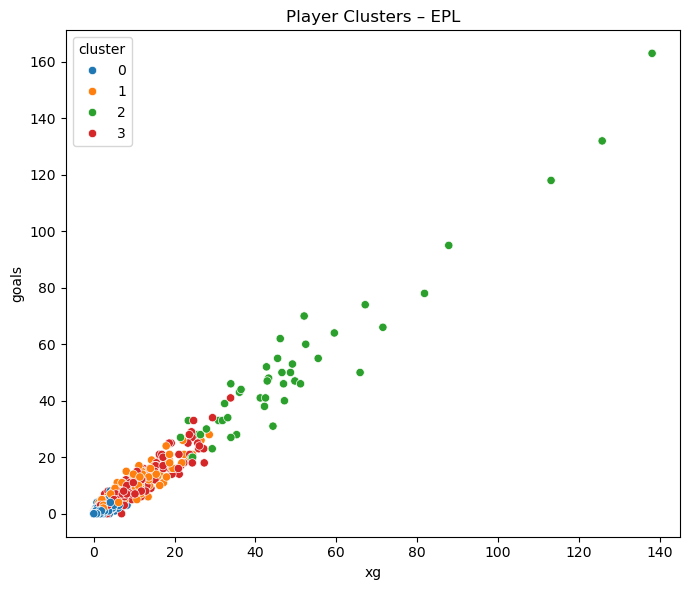

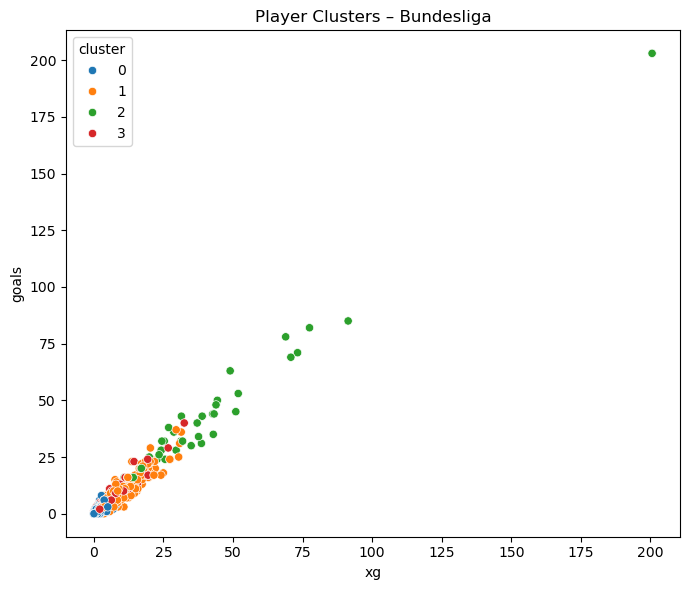

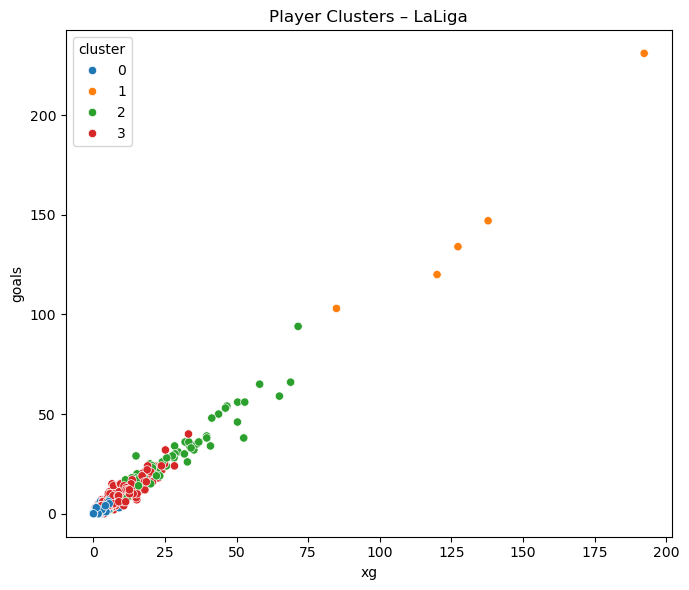

Player not found


In [ ]:
features = ["goals_per90","shots","xg","xa","minutes"]

for league in leagues:
    league_df = df[df["League"] == league].dropna(subset=features)

    scaler = StandardScaler()
    X = scaler.fit_transform(league_df[features])

    kmeans = KMeans(n_clusters=4, random_state=42)
    league_df["cluster"] = kmeans.fit_predict(X)

    plt.figure(figsize=(7,6))
    sns.scatterplot(
        data=league_df,
        x="xg",
        y="goals",
        hue="cluster",
        palette="tab10"
    )
    plt.title(f"Player Clusters – {league}")
    plt.tight_layout()
    plt.show()



In [61]:
features = ["goals_per90","shots","xg","xa","xg_chain","xg_build","assists"]
cluster_df = df.dropna(subset=features).copy()
X = cluster_df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_df["cluster"] = kmeans.fit_predict(X_scaled)


def find_similar_players(player_name, top_n=5):
    subset = cluster_df.copy()
    
    if player_name not in subset["Player Name"].values:
        print("Player not found")
        return
    
    target = subset[subset["Player Name"] == player_name][features]
    similarity = cosine_similarity(
        scaler.transform(target),
        scaler.transform(subset[features])
    )[0]
    
    subset["similarity"] = similarity
    result = subset.sort_values("similarity", ascending=False).head(top_n+1)
    
    print(result[["Player Name","Team Name","League","similarity"]])
name=input("Enter the player name:")
find_similar_players(name)

            Player Name        Team Name      League  similarity
1485         Harry Kane        Tottenham         EPL    1.000000
877       Sergio Agüero  Manchester City         EPL    0.997212
5058  Cristiano Ronaldo      Real Madrid      LaLiga    0.995267
435   Christian Benteke   Crystal Palace         EPL    0.994084
2871      Robin Quaison         Mainz 05  Bundesliga    0.993929
497       Romelu Lukaku          Everton         EPL    0.992481


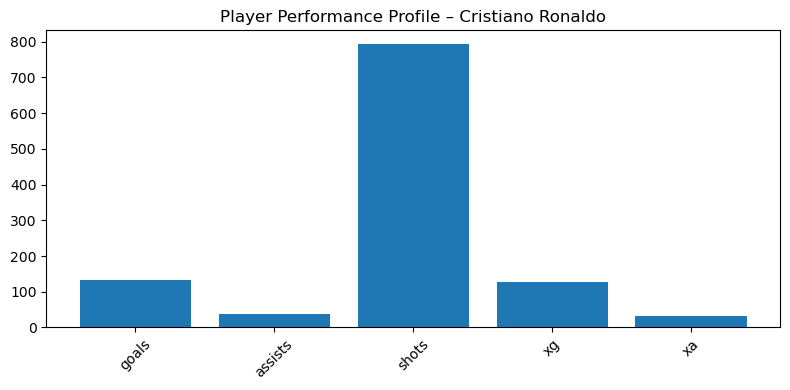

In [ ]:
def plot_player_profile(player_name):
    p = df[df["Player Name"] == player_name]

    if p.empty:
        print("Player not found")
        return

    metrics = ["goals","assists","shots","xg","xa","xg_build"]
    values = p[metrics].values[0]

    plt.figure(figsize=(8,4))
    plt.bar(metrics, values)
    plt.title(f"Player Performance Profile – {player_name}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
name=input("Enter the player name:")
plot_player_profile(name)


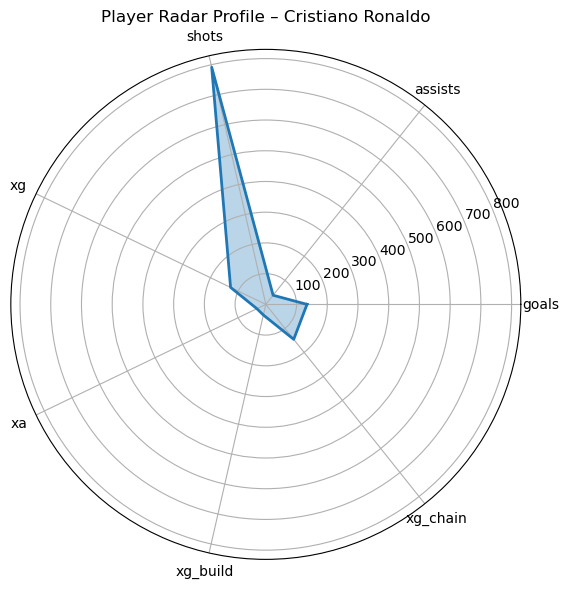

In [47]:
def plot_player_radar(player_name):
    p = df[df["Player Name"] == player_name]

    if p.empty:
        print("Player not found")
        return

    metrics = ["goals","assists","shots","xg","xa","xg_build","xg_chain"]
    values = p[metrics].values[0]

    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
    values = np.append(values, values[0])
    angles = np.append(angles, angles[0])

    plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)

    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.3)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)

    ax.set_title(f"Player Radar Profile – {player_name}", pad=20)
    plt.tight_layout()
    plt.show()

name = input("Enter player name: ")
plot_player_radar(name)


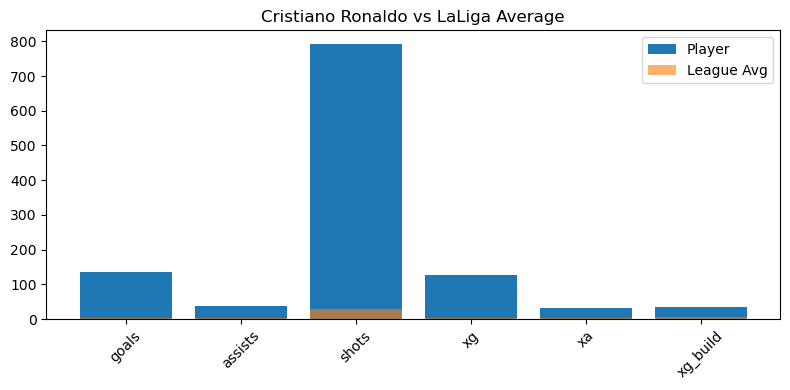

In [51]:
def plot_player_vs_league(player_name):
    p = df[df["Player Name"] == player_name]

    if p.empty:
        print("Player not found")
        return

    league = p["League"].values[0]
    league_avg = df[df["League"] == league].mean(numeric_only=True)

    metrics = ["goals","assists","shots","xg","xa","xg_build"]

    player_vals = p[metrics].values[0]
    avg_vals = league_avg[metrics].values

    x = range(len(metrics))

    plt.figure(figsize=(8,4))
    plt.bar(x, player_vals, label="Player")
    plt.bar(x, avg_vals, alpha=0.6, label="League Avg")

    plt.xticks(x, metrics, rotation=45)
    plt.title(f"{player_name} vs {league} Average")
    plt.legend()
    plt.tight_layout()
    plt.show()

name = input("Enter player name: ")
plot_player_vs_league(name)


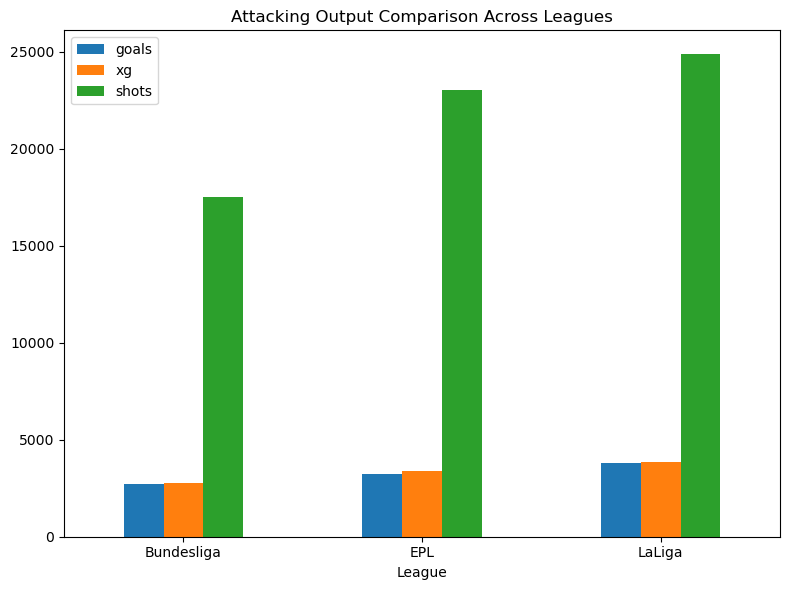

In [21]:
league_attack = (
    df[df["unit"] == "Attacking"]
    .groupby("League")[["goals","xg","shots"]]
    .sum()
)

league_attack.plot(kind="bar", figsize=(8,6))
plt.title("Attacking Output Comparison Across Leagues")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


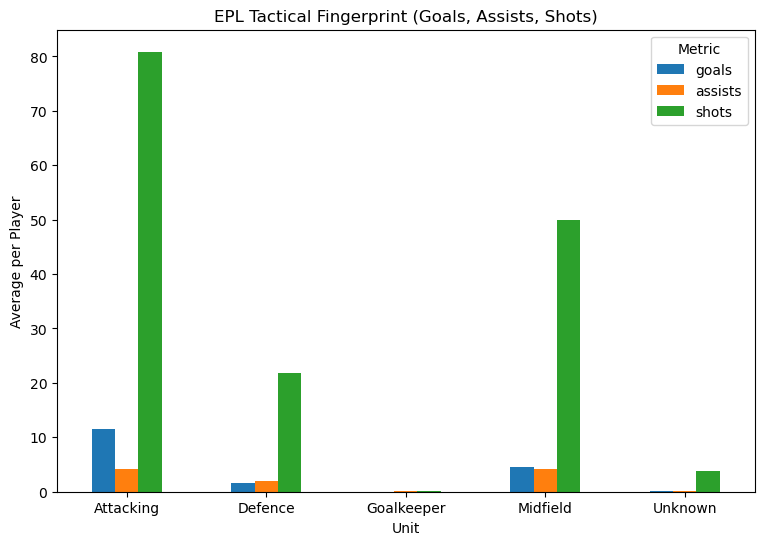

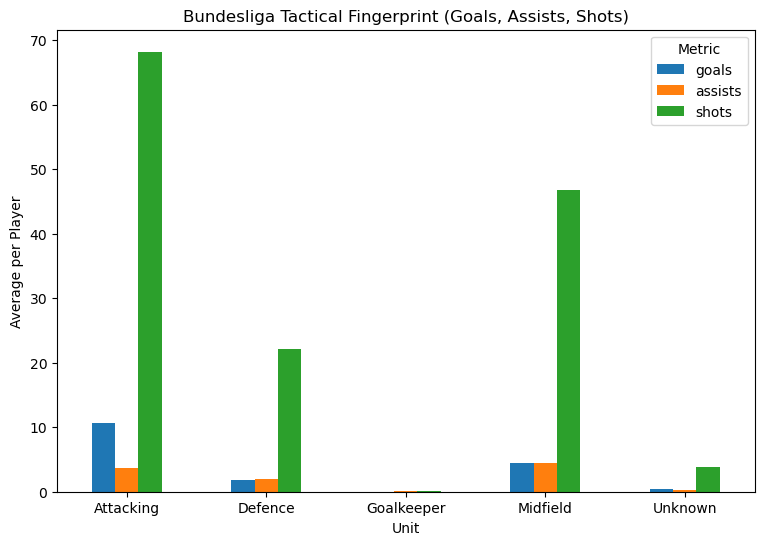

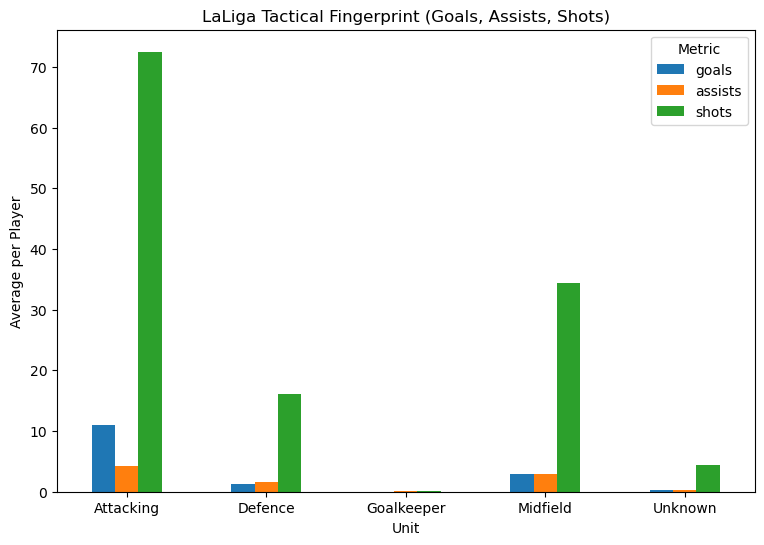

In [67]:
import matplotlib.pyplot as plt

metrics = ["goals", "assists", "shots"]

for league in leagues:

    league_df = df[df["League"] == league]

    team_style = (
        league_df
        .groupby("unit")[metrics]
        .mean()
    )

    fig, ax = plt.subplots(figsize=(9,6))

    team_style.plot(
        kind="bar",
        ax=ax
    )

    ax.set_title(f"{league} Tactical Fingerprint (Goals, Assists, Shots)")
    ax.set_xlabel("Unit")
    ax.set_ylabel("Average per Player")
    ax.legend(title="Metric")
    plt.xticks(rotation=0)
    plt.show()


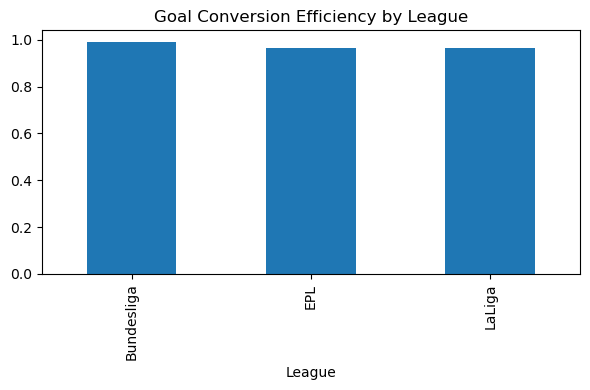

In [26]:
eff = (
    df.groupby("League")[["goals","xg"]]
    .sum()
)
eff["conversion_efficiency"] = eff["goals"] / eff["xg"]

eff["conversion_efficiency"].plot(kind="bar", figsize=(6,4))
plt.title("Goal Conversion Efficiency by League")
plt.tight_layout()
plt.show()


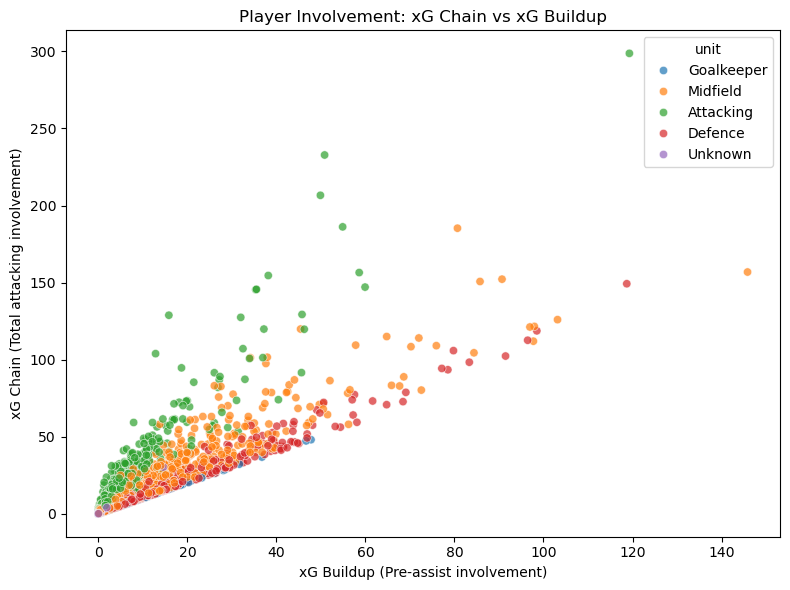

In [28]:
plt.figure(figsize=(8,6))

sns.scatterplot(
    data=df,
    x="xg_build",
    y="xg_chain",
    hue="unit",
    alpha=0.7
)

plt.xlabel("xG Buildup (Pre-assist involvement)")
plt.ylabel("xG Chain (Total attacking involvement)")
plt.title("Player Involvement: xG Chain vs xG Buildup")
plt.tight_layout()
plt.show()


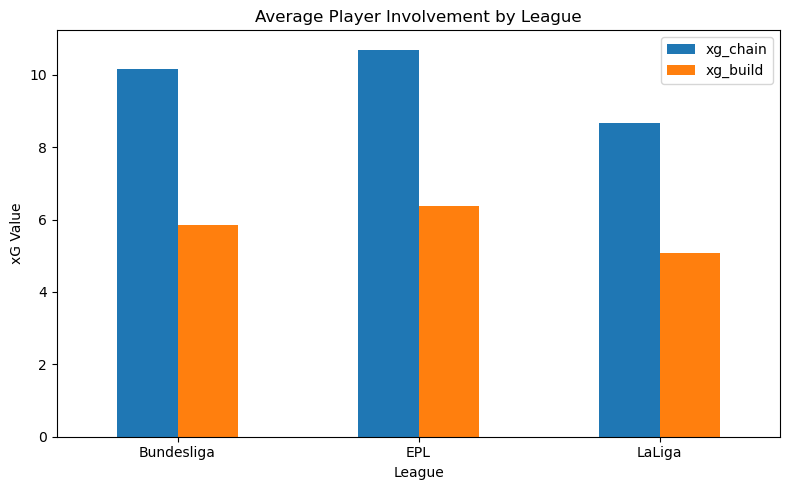

In [68]:
league_xg = (
    df.groupby("League")[["xg_chain","xg_build"]]
    .mean()
)

ax = league_xg.plot(kind="bar", figsize=(8,5))
ax.set_title("Average Player Involvement by League")
ax.set_ylabel("xG Value")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


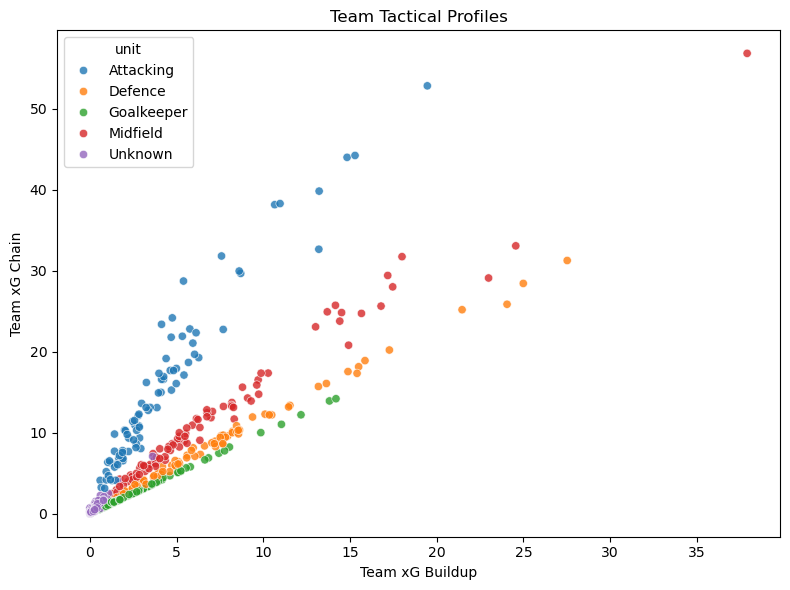

In [31]:
team_style = (
    df.groupby(["Team Name","unit"])
    [["xg_chain","xg_build"]]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=team_style,
    x="xg_build",
    y="xg_chain",
    hue="unit",
    alpha=0.8
)

plt.xlabel("Team xG Buildup")
plt.ylabel("Team xG Chain")
plt.title("Team Tactical Profiles")
plt.tight_layout()
plt.show()


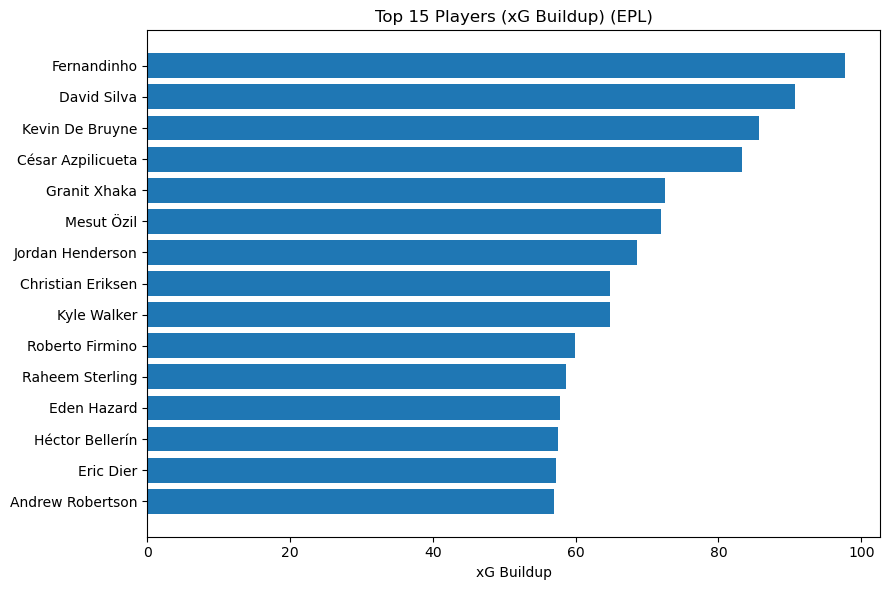

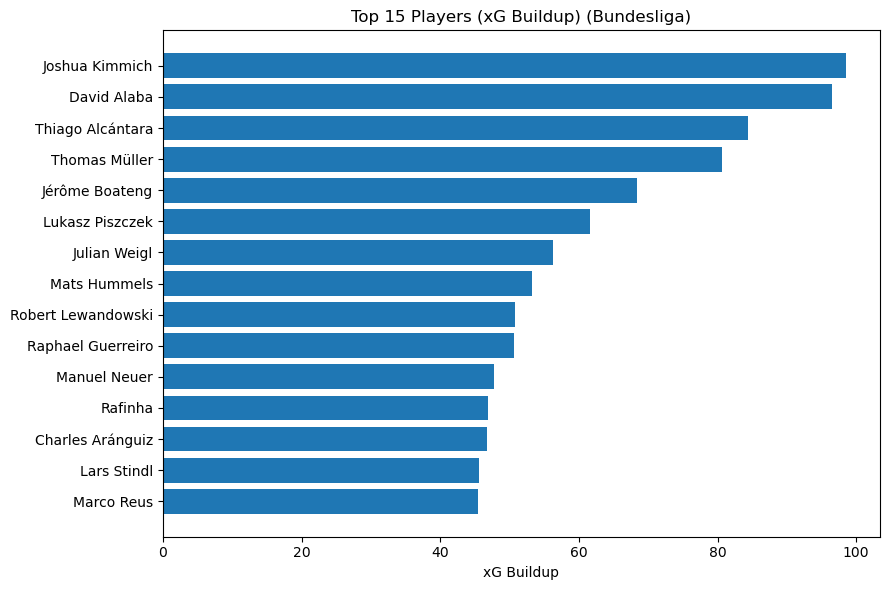

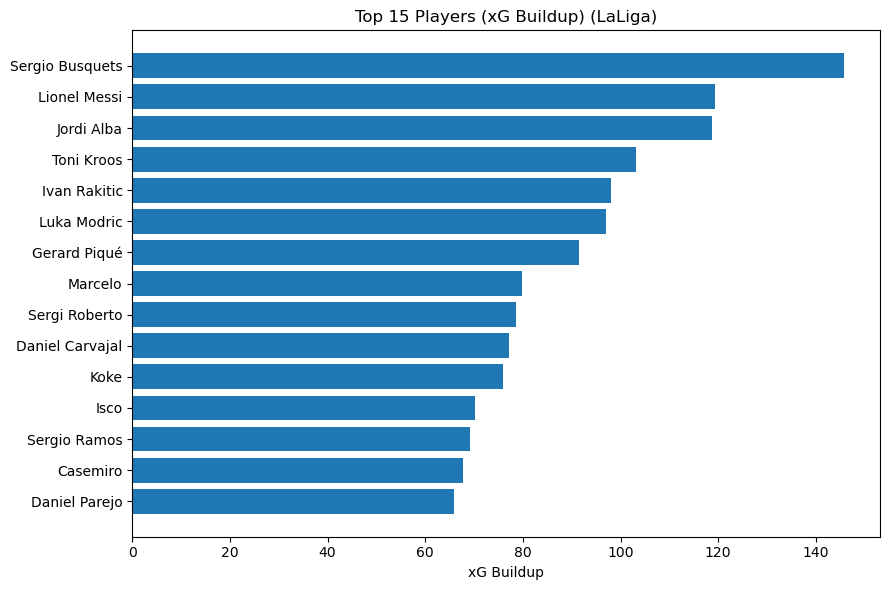

In [69]:
for league in leagues:

    league_df = df[df["League"] == league]

    top_build = league_df.sort_values("xg_build", ascending=False).head(15)

    plt.figure(figsize=(9,6))
    plt.barh(top_build["Player Name"], top_build["xg_build"])
    
    plt.xlabel("xG Buildup")
    plt.title(f"Top 15 Players (xG Buildup) ({league})")
    plt.gca().invert_yaxis()
    
    plt.tight_layout()
    plt.show()


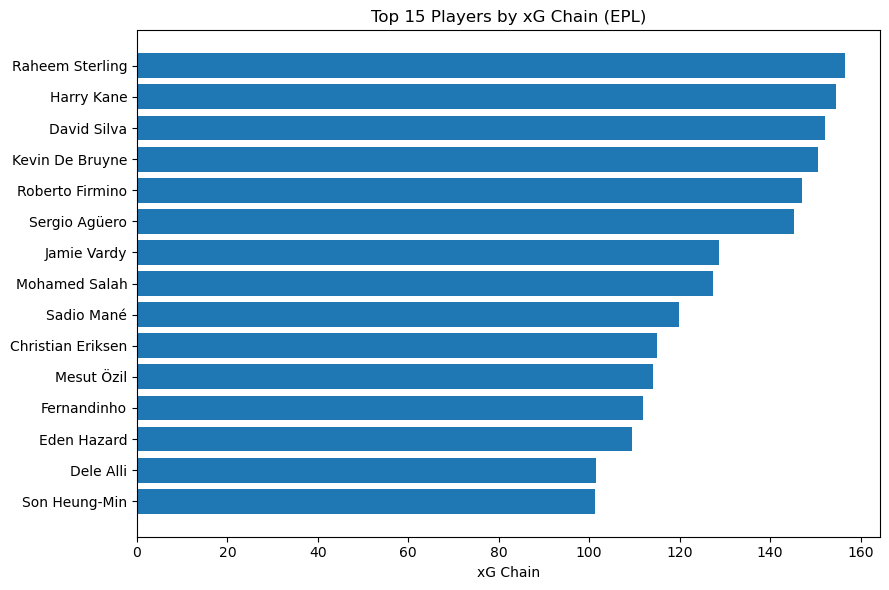

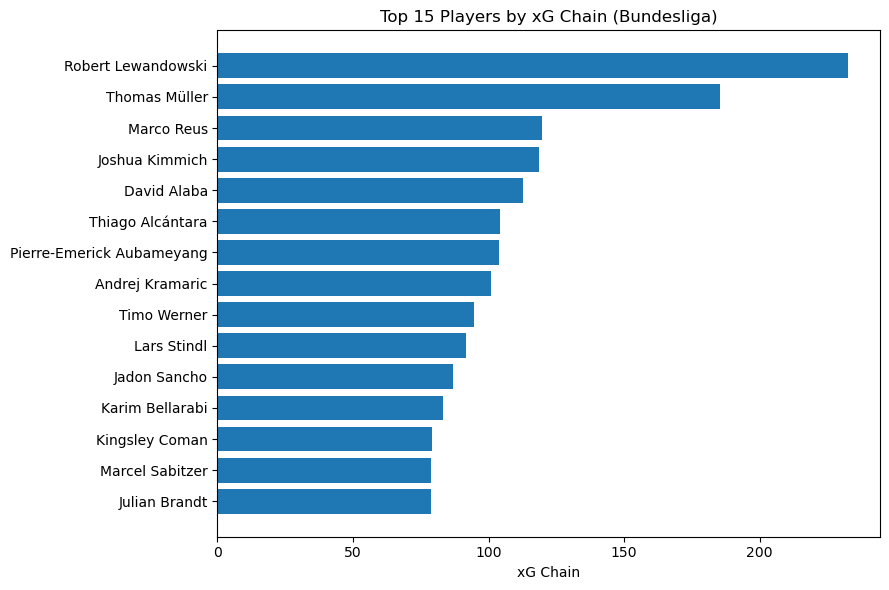

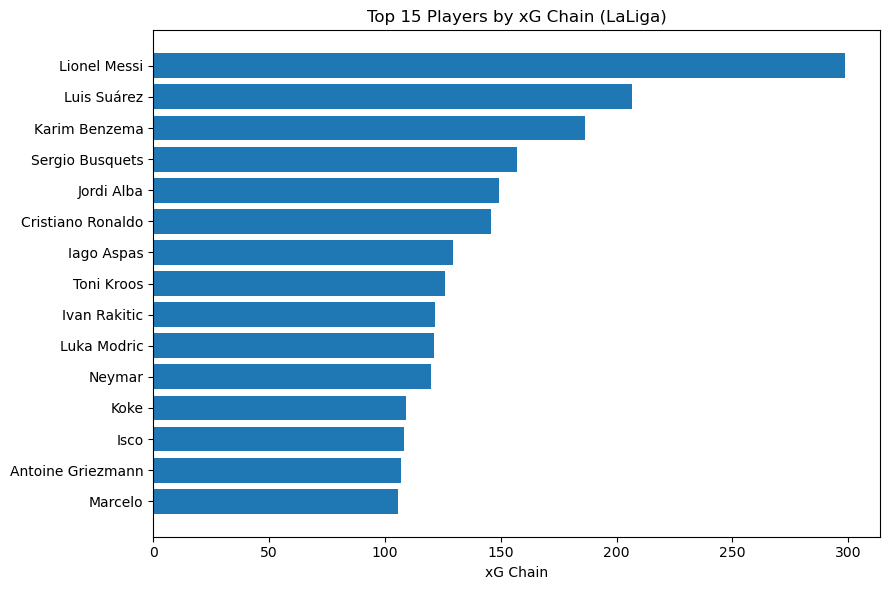

In [46]:
for league in leagues:

    league_df = df[df["League"] == league]

    top_chain = league_df.sort_values("xg_chain", ascending=False).head(15)

    plt.figure(figsize=(9,6))
    plt.barh(top_chain["Player Name"], top_chain["xg_chain"])
    
    plt.xlabel("xG Chain")
    plt.title(f"Top 15 Players by xG Chain ({league})")
    plt.gca().invert_yaxis()
    
    plt.tight_layout()
    plt.show()



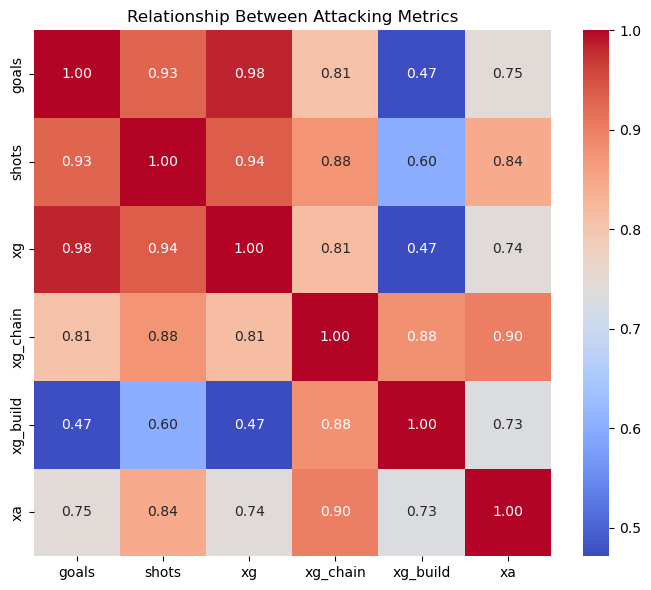

In [36]:
features = ["goals","shots","xg","xg_chain","xg_build","xa"]

corr = df[features].corr()

plt.figure(figsize=(7,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Relationship Between Attacking Metrics")
plt.tight_layout()
plt.show()


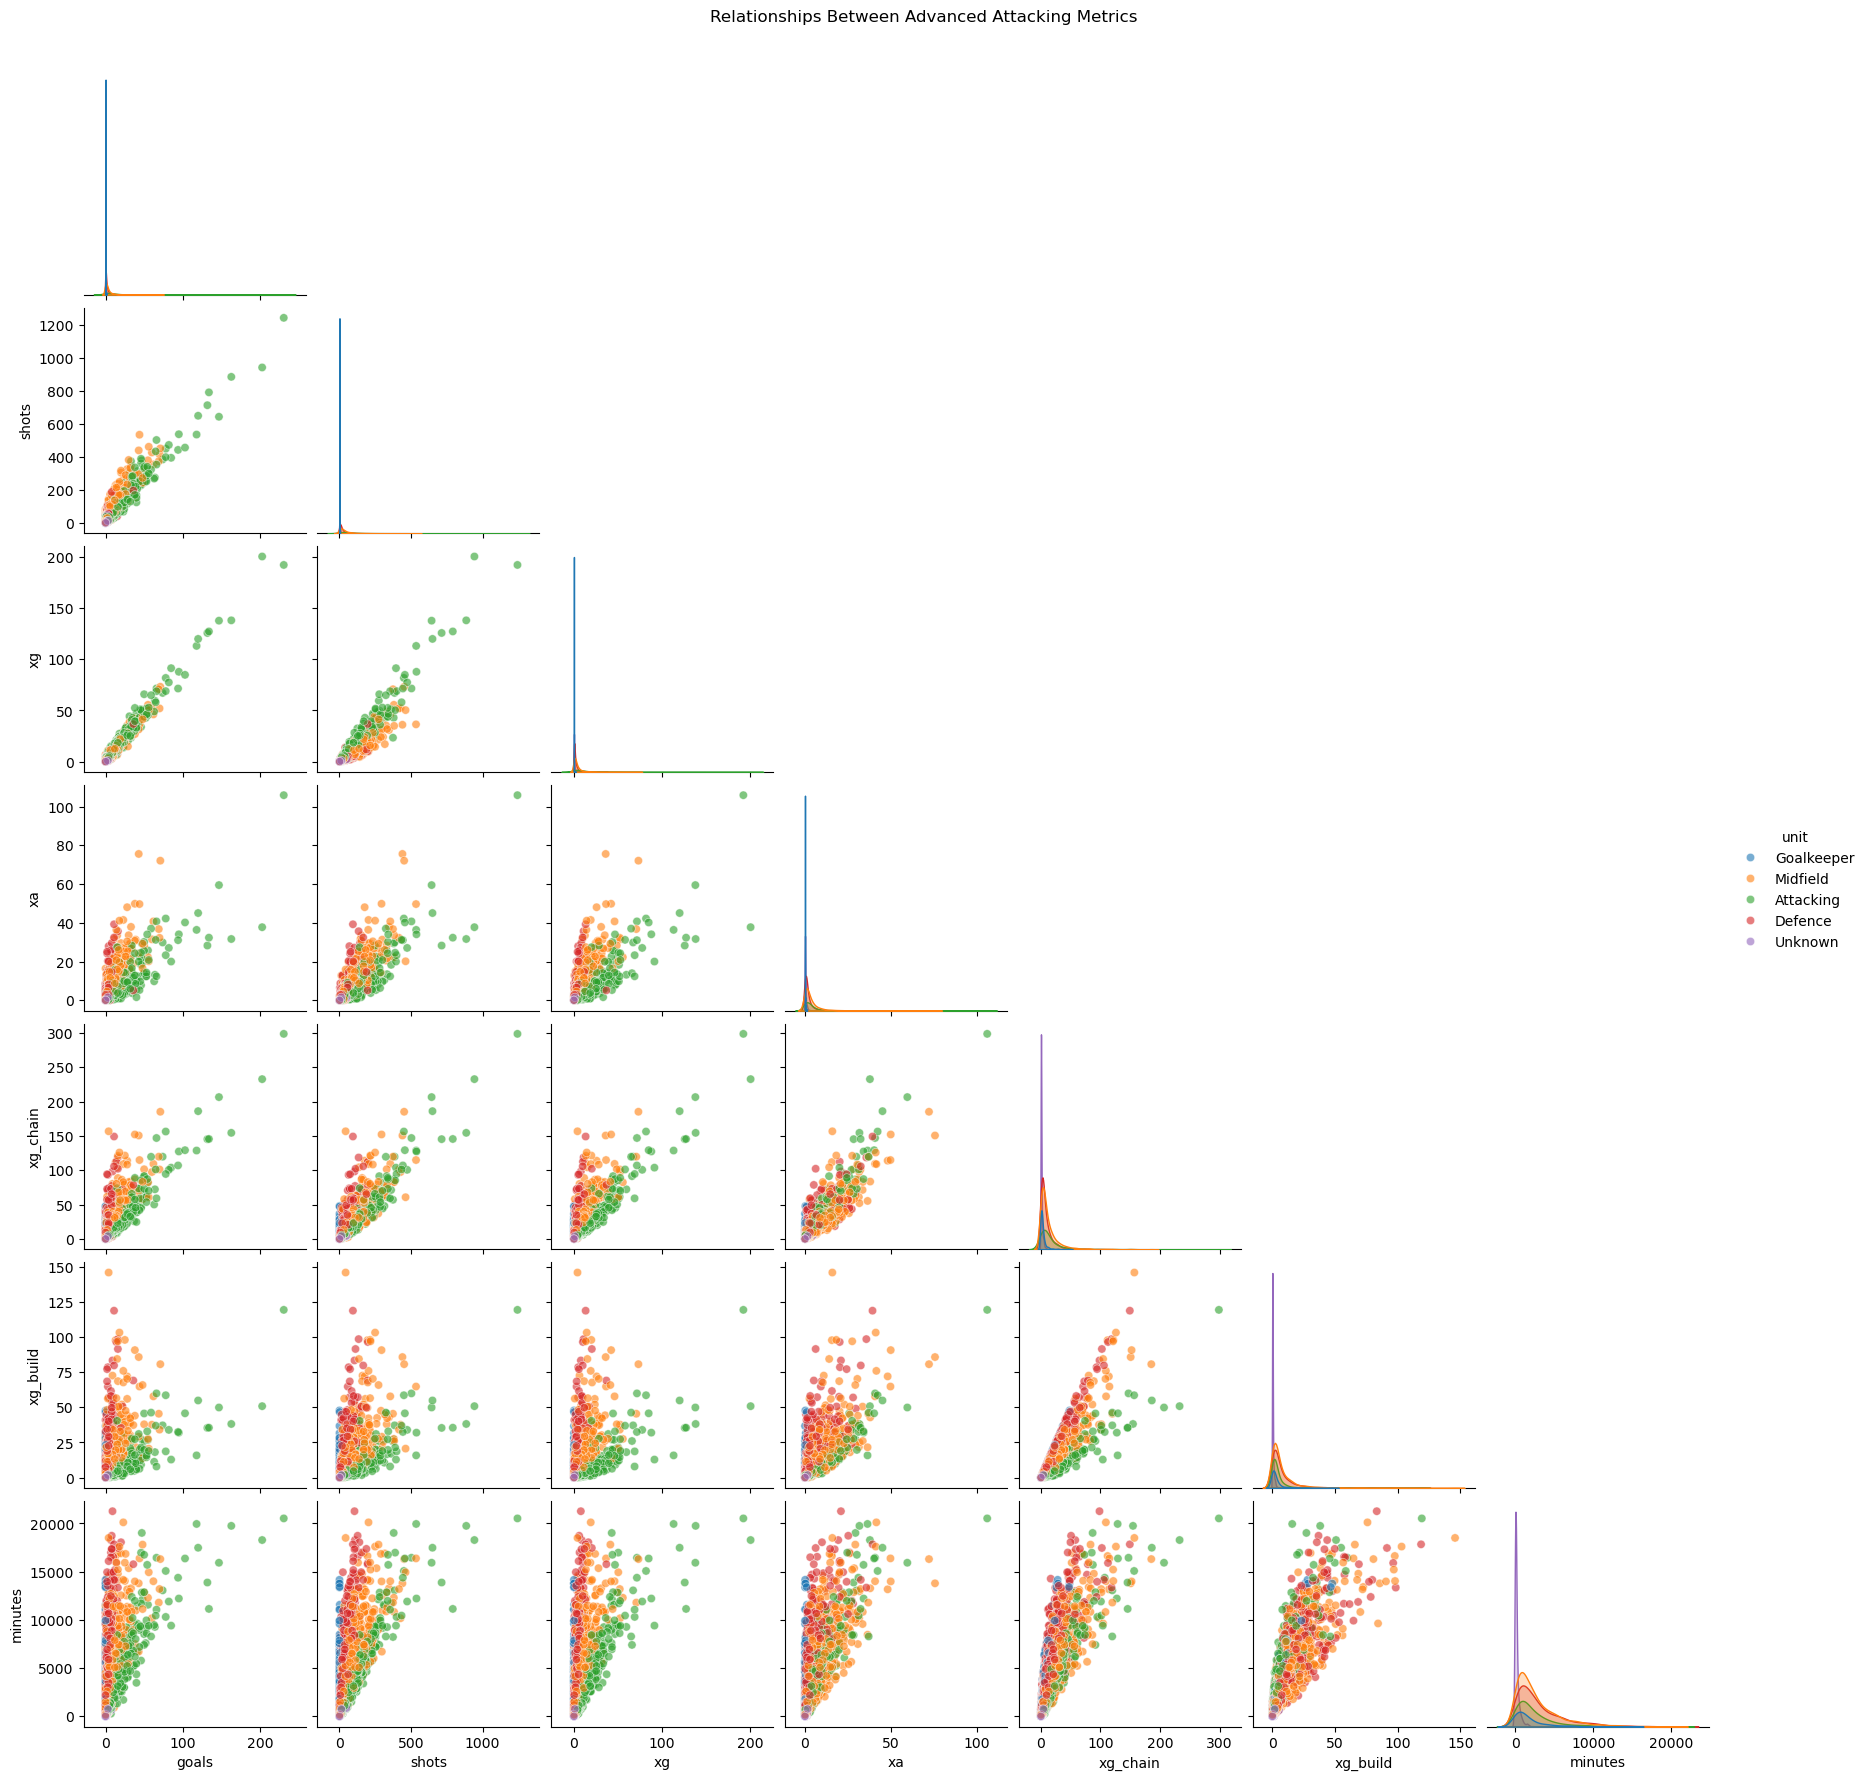

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

features = [
    "goals",
    "shots",
    "xg",
    "xa",
    "xg_chain",
    "xg_build",
    "minutes"
]

sns.pairplot(
    df[features + ["unit"]],
    hue="unit",
    corner=True,
    plot_kws={"alpha": 0.6}
)

plt.suptitle("Relationships Between Advanced Attacking Metrics", y=1.02)
plt.show()


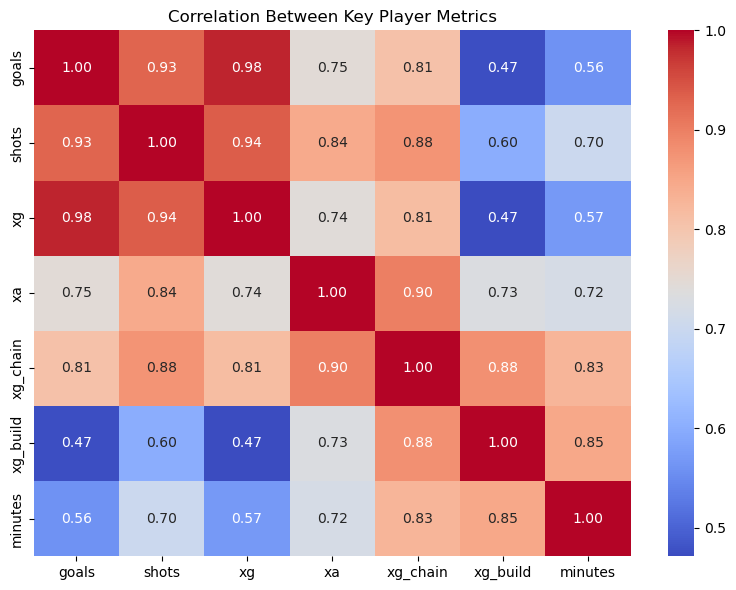

In [38]:
plt.figure(figsize=(8,6))

corr = df[features].corr()

sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)

plt.title("Correlation Between Key Player Metrics")
plt.tight_layout()
plt.show()


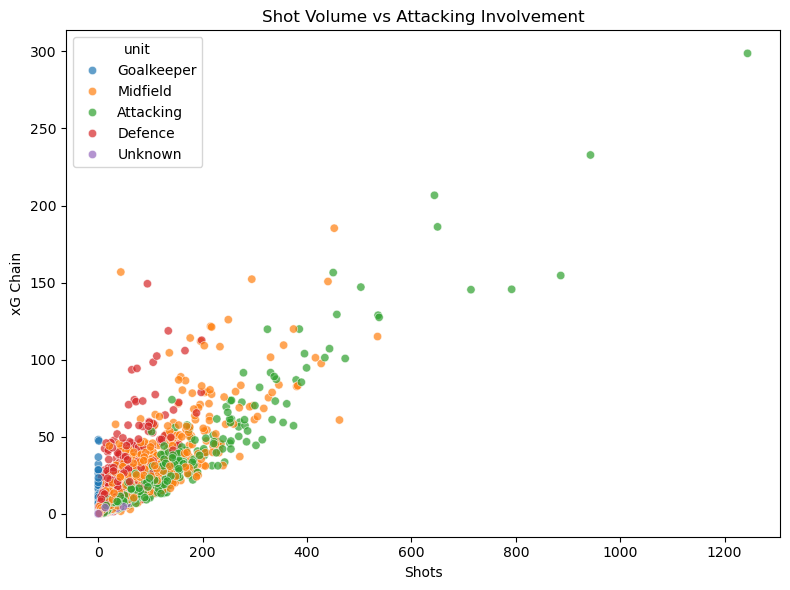

In [40]:
plt.figure(figsize=(8,6))

sns.scatterplot(
    data=df,
    x="shots",
    y="xg_chain",
    hue="unit",
    alpha=0.7
)

plt.xlabel("Shots")
plt.ylabel("xG Chain")
plt.title("Shot Volume vs Attacking Involvement")
plt.tight_layout()
plt.show()


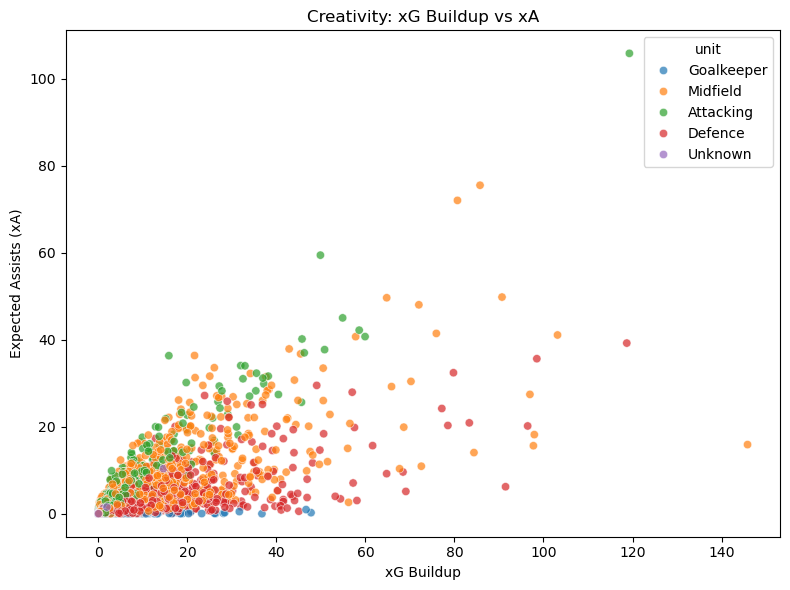

In [42]:
plt.figure(figsize=(8,6))

sns.scatterplot(
    data=df,
    x="xg_build",
    y="xa",
    hue="unit",
    alpha=0.7
)

plt.xlabel("xG Buildup")
plt.ylabel("Expected Assists (xA)")
plt.title("Creativity: xG Buildup vs xA")
plt.tight_layout()
plt.show()


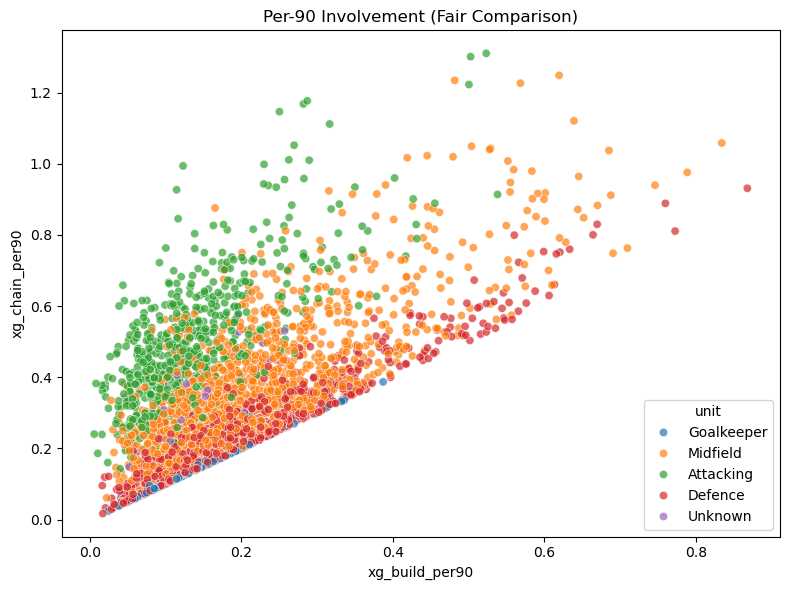

In [43]:
per90 = df[df["minutes"] >= 900].copy()

for col in ["xg_chain", "xg_build", "shots", "xa"]:
    per90[f"{col}_per90"] = per90[col] / per90["minutes"] * 90

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=per90,
    x="xg_build_per90",
    y="xg_chain_per90",
    hue="unit",
    alpha=0.7
)

plt.title("Per-90 Involvement (Fair Comparison)")
plt.tight_layout()
plt.show()


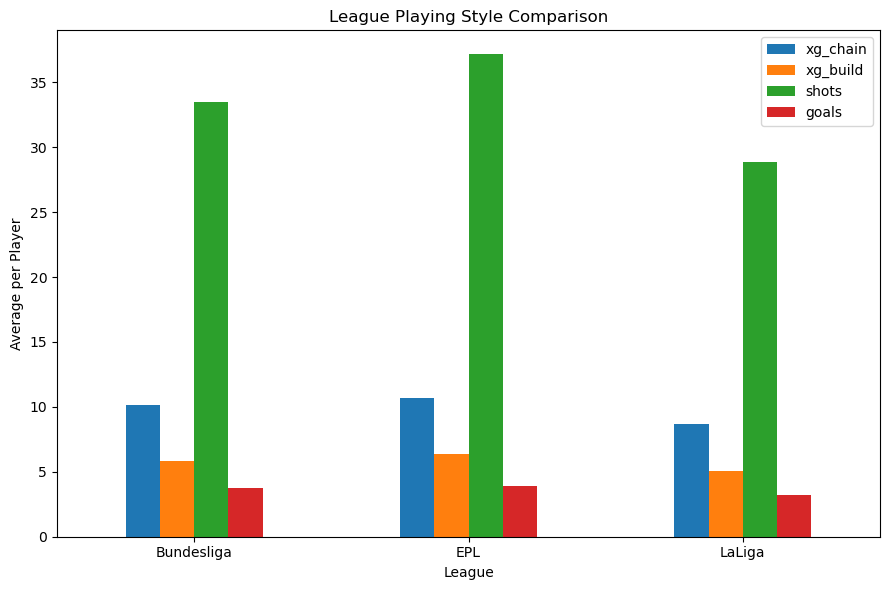

In [44]:
league_style = (
    df.groupby("League")
    [["xg_chain","xg_build","shots","goals"]]
    .mean()
)

league_style.plot(kind="bar", figsize=(9,6))
plt.title("League Playing Style Comparison")
plt.ylabel("Average per Player")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
